# <center> Linear Classification and Regression
## <center> An Illustrative Example of Logistic Regression Regularization

In the first article, we demonstrated how polynomial features allow linear models to build nonlinear separating surfaces. Let's now show this visually.

Let's see how regularization affects the quality of classification on a dataset on microchip testing from Andrew Ng's course on machine learning. We will use logistic regression with polynomial features and vary the regularization parameter $C$. First, we will see how regularization affects the separating border of the classifier and intuitively recognize under- and overfitting. Then, we will choose the regularization parameter to be numerically close to the optimal value via (`cross-validation`) and (`GridSearch`).

In [1]:
# we don't like warnings
# you can comment the following 2 lines if you'd like to
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score)
from sklearn.preprocessing import PolynomialFeatures

Let's load the data using `read_csv` from the `pandas` library. In this dataset on 118 microchips (objects), there are results for two tests of quality control (two numerical variables) and information whether the microchip went into production. Variables are already centered, meaning that the column values have had their own mean values subtracted. Thus, the "average" microchip corresponds to a zero value in the test results.  

In [4]:
# loading data
data = pd.read_csv(
    "../data/microchip_tests.txt", header=None, names=("test1", "test2", "released")
)
# getting some info about dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   test1     118 non-null    float64
 1   test2     118 non-null    float64
 2   released  118 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.9 KB


Let's inspect at the first and last 5 lines.

In [5]:
data.head(5)

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [6]:
data.tail(5)

,test1,test2,released
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0
117,0.632650,-0.030612,0


Now we should save the training set and the target class labels in separate NumPy arrays.

In [7]:
X = data.iloc[:, :2].values
y = data.iloc[:, 2].values

As an intermediate step, we can plot the data. Orange points correspond to defective chips, blue to normal ones.

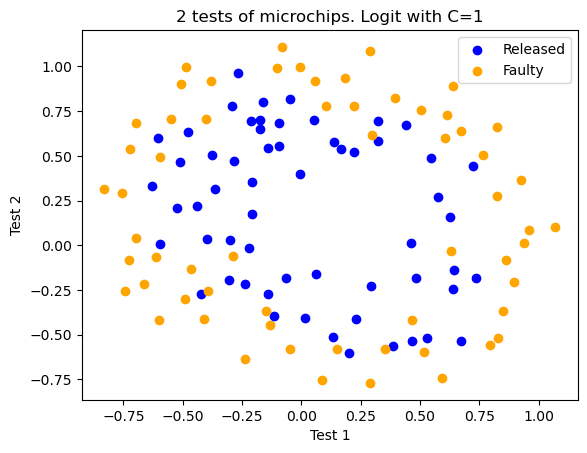

In [8]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=1")
plt.legend();

Let's define a function to display the separating curve of the classifier.

In [9]:
def plot_boundary(clf, X, y, grid_step=0.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, grid_step), np.arange(y_min, y_max, grid_step)
    )

    # to every point from [x_min, m_max]x[y_min, y_max]
    # we put in correspondence its own color
    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

We define the following polynomial features of degree $d$ for two variables $x_1$ and $x_2$:

$$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} =  \{x_1^ix_2^j\}_{i+j=d, i,j \in \mathbb{N}}$$

For example, for $d=3$, this will be the following features:

$$\large 1, x_1, x_2,  x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$$

Drawing a Pythagorean Triangle would show how many of these features there will be for $d=4,5...$ and so on.
The number of such features is exponentially large, and it can be costly to build polynomial features of large degree (e.g $d=10$) for 100 variables. More importantly, it's not needed. 


We will use `sklearn`'s implementation of logistic regression. So, we create an object that will add polynomial features up to degree 7 to matrix $X$.

In [10]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

In [11]:
X_poly.shape

(118, 36)

Let's train logistic regression with regularization parameter $C = 10^{-2}$.

Accuracy on training set: 0.627


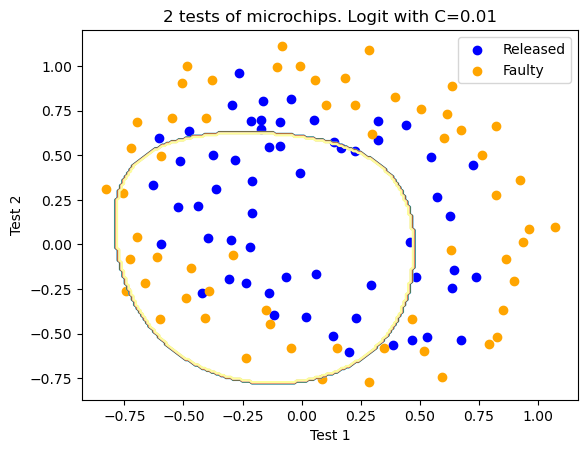

In [12]:
C = 1e-2
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

We could now try increasing $C$ to 1. In doing this, we weaken regularization, and the solution can now have greater values (in absolute value) of model weights than previously. Now the accuracy of the classifier on the training set improves to 0.831.

Accuracy on training set: 0.831


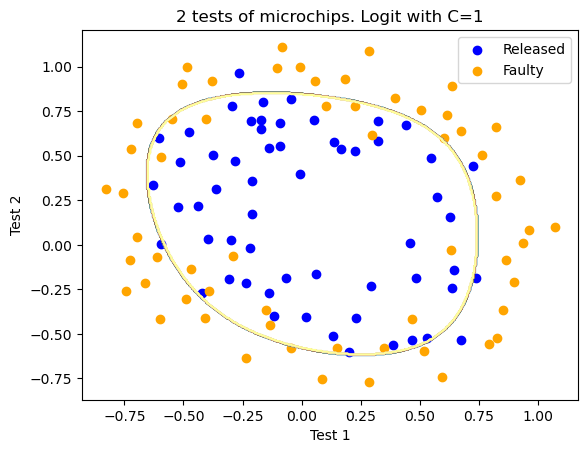

In [13]:
C = 1
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

Then, why don't we increase $C$ even more - up to 10,000? Now, regularization is clearly not strong enough, and we see overfitting. Note that, with $C$=1 and a "smooth" boundary, the share of correct answers on the training set is not much lower than here. But one can easily imagine how our second model will work much better on new data.

Accuracy on training set: 0.881


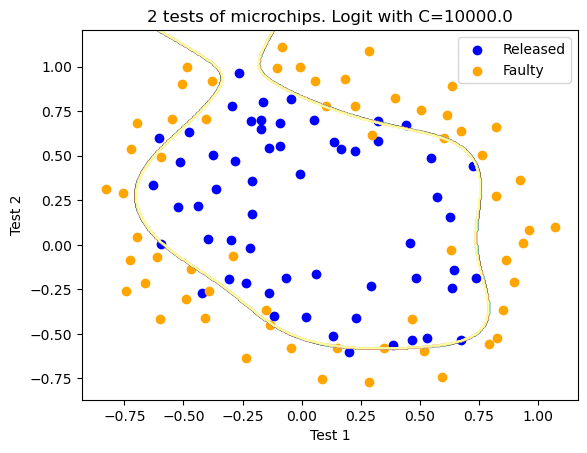

In [14]:
C = 1e4
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_poly, y)

plot_boundary(logit, X, y, grid_step=0.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c="blue", label="Released")
plt.scatter(X[y == 0, 0], X[y == 0, 1], c="orange", label="Faulty")
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title("2 tests of microchips. Logit with C=%s" % C)
plt.legend()

print("Accuracy on training set:", round(logit.score(X_poly, y), 3))

To discuss the results, let's rewrite the function that is optimized in logistic regression with the form:

$$\large J(X,y,w) = \mathcal{L} + \frac{1}{C}||w||^2,$$

where

- $\mathcal{L}$ is the logistic loss function summed over the entire dataset
- $C$ is the reverse regularization coefficient (the very same $C$ from `sklearn`'s implementation of `LogisticRegression`)

**Subtotals**:
- the larger the parameter $C$, the more complex the relationships in the data that the model can recover (intuitively $C$ corresponds to the "complexity" of the model - model capacity)
- if regularization is too strong i.e. the values of $C$ are small, the solution to the problem of minimizing the logistic loss function may be the one where many of the weights are too small or zeroed. The model is also not sufficiently "penalized" for errors (i.e. in the function $J$, the sum of the squares of the weights "outweighs", and the error $\mathcal{L}$ can be relatively large). In this case, the model will underfit as we saw in our first case.
- on the contrary, if regularization is too weak i.e. the values of $C$ are large, a vector $w$ with high absolute value components can become the solution to the optimization problem. In this case, $\mathcal{L}$ has a greater contribution to the optimized functional $J$. Loosely speaking, the model is too "afraid" to be mistaken on the objects from the training set and will therefore overfit as we saw in the third case.
- logistic regression will not "understand" (or "learn") what value of $C$ to choose as it does with the weights $w$. That is to say, it can not be determined by solving the optimization problem in logistic regression. We have seen a similar situation before -- a decision tree can not "learn" what depth limit to choose during the training process. Therefore, $C$ is the a model hyperparameter that is tuned on cross-validation; so is the max_depth in a tree.

**Regularization parameter tuning**

Using this example, let's identify the optimal value of the regularization parameter $C$. This can be done using `LogisticRegressionCV` - a grid search of parameters followed by cross-validation. This class is designed specifically for logistic regression (effective algorithms with well-known search parameters). For an arbitrary model, use `GridSearchCV`, `RandomizedSearchCV`, or special algorithms for hyperparameter optimization such as the one implemented in `hyperopt`.

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, verbose=1, n_jobs=-1)
logit_searcher.fit(X_poly, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrain

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51558D+01    |proj g|=  4.90728D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37      8     11      1     0     0   2.861D-05   6.450D+01
  F =   64.501668624499459     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.77069D+01    |proj g|=  7.64476D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67121D+01    |proj g|=  6.36049D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     10     12      1     0     0   9.344D-05   5.771D+01
  F =   57.705138453697089     

CONVERGENCE: NORM_OF_PROJE

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations

Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     14     18      1     0     0   8.948D-04   4.160D+01
  F =   41.601197144177519     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     22     26      1     0     0   9.960D-05   3.329D+01
  F =   33.290884496759141     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.31909D+01    |proj g|=  8.60531D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     25     31      1     0     0   6.044D-04   2.875D+01
  F =   28.751805205180212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86835D+01    |proj g|=  3.76027D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18689D+01    |proj g|=  7.38114D-02
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83290D+01    |proj g|=  6.64346D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37      8     10      1     0     0   1.782D-03   5.833D+01
  F =   58.327562722515069     

CONVERGENCE: REL_REDUCTION

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     61     67      1     0     0   1.039D-04   2.362D+01
  F =   23.615618631904713     


CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate   50    f=  2.69316D+01    |proj g|=  7.32087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     22     25      1     0     0   3.149D-04   3.350D+01
  F =   33.501966100643855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.34418D+01    |proj g|=  3.63245D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.5s
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is uncons


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     26     32      1     0     0   4.859D-04   3.137D+01
  F =   31.367907191978777     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13282D+01    |proj g|=  1.97310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94451D+01    |proj g|=  1.20186D-03

At iterate   50    f=  2.91083D+01    |proj g|=  5.27321D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     50     56      1     0     0   5.273D-04   2.911D+01
  F =   29.108345877327711     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 v

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


LogisticRegressionCV(Cs=array([1.00000000e-02, 1.02334021e-02, 1.04722519e-02, 1.07166765e-02,
       1.09668060e-02, 1.12227736e-02, 1.14847155e-02, 1.17527712e-02,
       1.20270833e-02, 1.23077980e-02, 1.25950646e-02, 1.28890361e-02,
       1.31898690e-02, 1.34977233e-02, 1.38127630e-02, 1.41351558e-02,
       1.44650734e-02, 1.48026913e-02, 1.51481892e-02, 1.55017512e-02,
       1.58635653e-02, 1.62...
       6.45088409e+02, 6.60144909e+02, 6.75552832e+02, 6.91320378e+02,
       7.07455942e+02, 7.23968114e+02, 7.40865683e+02, 7.58157646e+02,
       7.75853206e+02, 7.93961785e+02, 8.12493021e+02, 8.31456781e+02,
       8.50863158e+02, 8.70722485e+02, 8.91045332e+02, 9.11842520e+02,
       9.33125118e+02, 9.54904456e+02, 9.77192128e+02, 1.00000000e+03]),
                     cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                     n_jobs=-1, verbose=1)

In [18]:
logit_searcher.C_

array([150.78450459])

To see how the quality of the model (percentage of correct responses on the training and validation sets) varies with the hyperparameter $C$, we can plot the graph. 

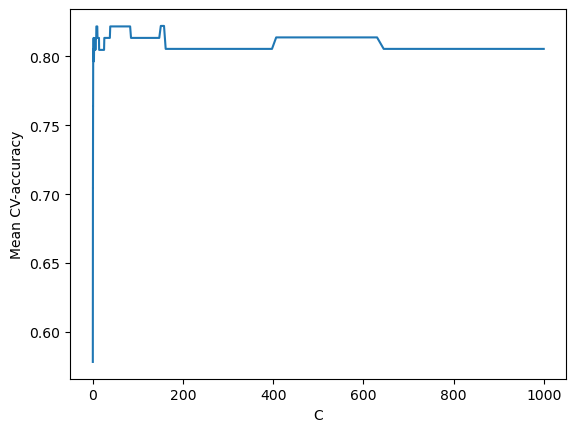

In [19]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel("C")
plt.ylabel("Mean CV-accuracy");

Finally, select the area with the "best" values of $C$.

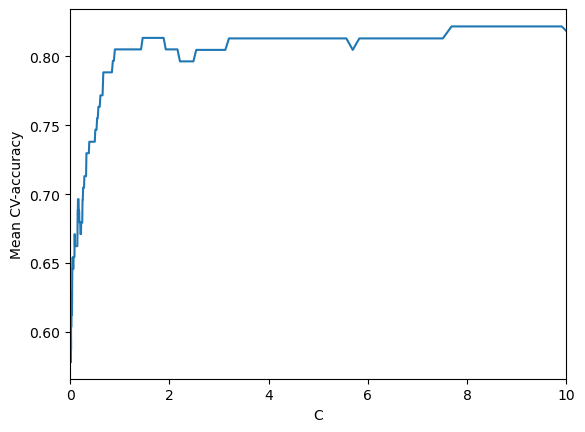

In [20]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel("C")
plt.ylabel("Mean CV-accuracy")
plt.xlim((0, 10));

Recall that these curves are called validation curves. Previously, we built them manually, but sklearn has special methods to construct these that we will use going forward.